# 원핫 + GBDT
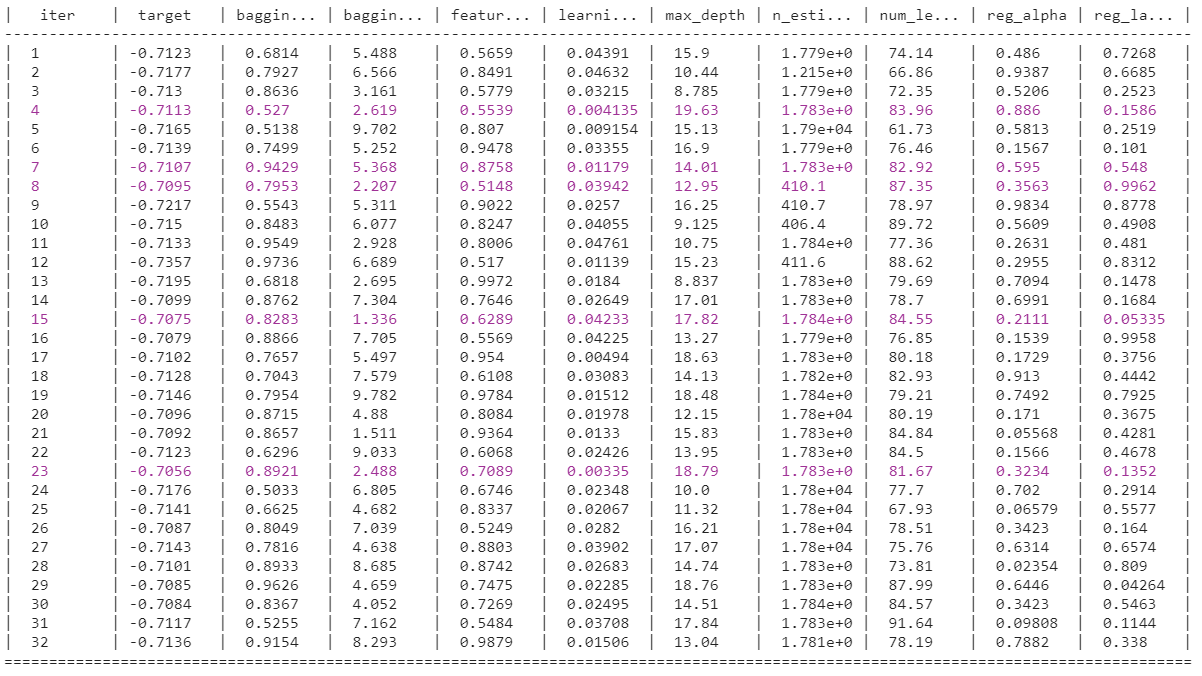

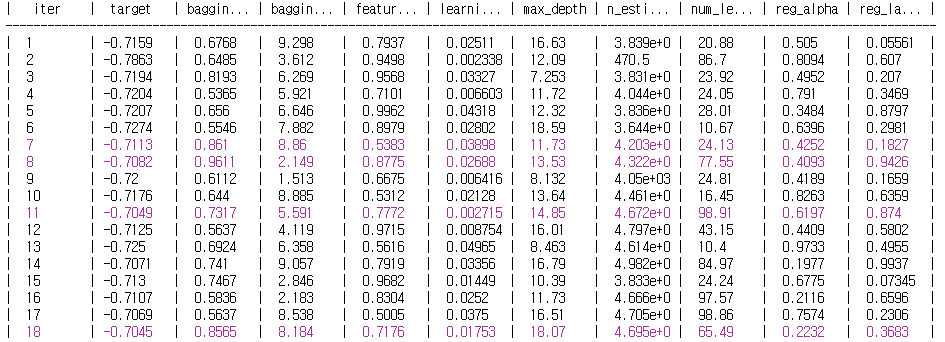

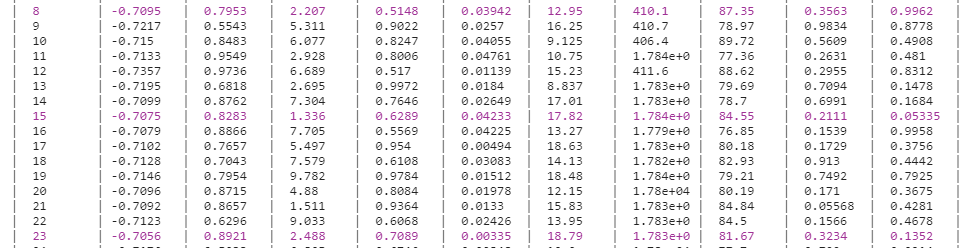

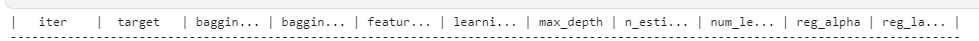

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import random
import os
from sklearn.metrics import log_loss
from bayes_opt import BayesianOptimization
import lightgbm


d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)
print(lst)
train = pd.read_csv(d + '\\' +lst[3])
test = pd.read_csv(d + '\\' +lst[2])
ss = pd.read_csv(d + '\\' +lst[1])
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

# Married, Civil marriage
train['income_per_size'] = np.log(train['income_total']/train['family_size'])
test['income_per_size'] = np.log(test['income_total']/test['family_size'])
train.loc[(train['family_type']=='Married')|(train['family_type']=='Civil marriage'),'income_per_size']\
= train['income_per_size'] * 2

test.loc[(test['family_type']=='Married')|(test['family_type']=='Civil marriage'),'income_per_size']\
= test['income_per_size'] * 2

def simple_marry(x):
    if x == 'Married' or x =='Civil marriage':
        return '0'
    elif x == 'Separated' or x == 'Widow':
        return '1'
    else:
        return '2'

for df in [train,test]:
    df['family_bins'] = df['family_type'].apply(simple_marry)

# income_total을 로그변환
train['income_total'] = np.log(train['income_total'])
# train = train.drop('income_total',1)
test['income_total'] = np.log(test['income_total'])
# test = test.drop('income_total',1)

# car와 reality를 합친 새로운 칼럼 careality
train['car'] =train['car'].apply(lambda x: int(x=='Y'))
train['reality'] =train['reality'].apply(lambda x: int(x=='Y'))
test['car'] =test['car'].apply(lambda x: int(x=='Y'))
test['reality'] =test['reality'].apply(lambda x: int(x=='Y'))

train['careality'] = train['car'] + train['reality']
train = train.drop(['car', 'reality'],1)

test['careality'] = test['car'] + test['reality']
test = test.drop(['car', 'reality'],1)

train.drop('gender',1,inplace=True)
test.drop('gender',1,inplace=True)

object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

#############################################################
# enc = LabelEncoder()
# # enc.fit(train.loc[:,object_col])
# total = pd.concat([train, test])

# for col in object_col:
#     enc.fit(total[col])
#     train[col] = enc.transform(train[col])
#     test[col] = enc.transform(test[col])

# train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
#              columns=enc.get_feature_names(object_col))
# train.drop(object_col, axis=1, inplace=True)
# train = pd.concat([train, train_onehot_df], axis=1)

# test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
#              columns=enc.get_feature_names(object_col))
# test.drop(object_col, axis=1, inplace=True)
# test = pd.concat([test, test_onehot_df], axis=1)
#############################################################




## 제곱
for df in [train,test]:
    df['income_per_size'] = df['income_per_size'].apply(lambda x: x**2)
    
c = 'income_per_size'
mean = train[c].mean()
std = train[c].std()

# 기존 
train[c] = (train[c]-mean)/std
test[c] = (test[c]-mean)/std

#####################
c = 'income_total'
k = 2.2
mean = train[c].mean()
std = train[c].std()
idxs = train.loc[(train[c]>= mean + k*std)|\
                (train[c]<= mean - k*std)].index
train = train.drop(idxs).reset_index(drop=True)

# 기존 
train[c] = (train[c]-mean)/std
test[c] = (test[c]-mean)/std

#####################
c = 'begin_month'
k = 2.2

train[c] = train[c].apply(lambda x: x**2)
test[c] = test[c].apply(lambda x: x**2)

mean = train[c].mean()
std = train[c].std()

idxs = train.loc[(train[c]>= mean + k*std)|\
                (train[c]<= mean - k*std)].index
# train = train.drop(idxs).reset_index(drop=True)

# 기존 
train[c] = (train[c]-mean)/std
test[c] = (test[c]-mean)/std

######################
c = 'DAYS_BIRTH'
k = 2.2
mean = train[c].mean()
std = train[c].std()
idxs = train.loc[(train[c]>= mean + k*std)|\
                (train[c]<= mean - k*std)].index
train = train.drop(idxs).reset_index(drop=True)

#기존 
train[c] = (train[c]-mean)/std
test[c] = (test[c]-mean)/std



###################
c = 'DAYS_EMPLOYED'
k = 2.2
mean = train[c].mean()
std = train[c].std()
idxs = train.loc[(train[c]>= mean + k*std)|\
                (train[c]<= mean - k*std)].index
train = train.drop(idxs).reset_index(drop=True)

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']


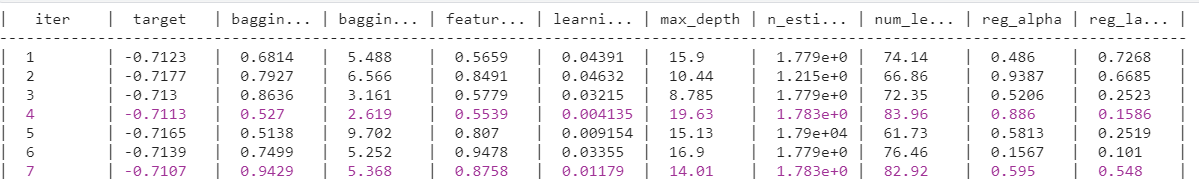

In [3]:
from sklearn.model_selection import GridSearchCV
grid = {        
    'n_estimators': range(1000,2001,100),
    'learning_rate': [0.03, 0.07,0.11],
    'max_depth': range(13,20),
    'num_leaves': range(81,88),
    'bagging_fraction': [0.5,0.7,0.9], 
    'bagging_freq': range(1,5),
    'feature_fraction': [0.5,0.7,0.9], 
    'reg_lambda': [0.3,0.6,0.9],
    'reg_alpha': [0.3,0.6,0.9]   
}

In [5]:
dir(lightgbm)

['Booster',
 'CVBooster',
 'DaskLGBMClassifier',
 'DaskLGBMRanker',
 'DaskLGBMRegressor',
 'Dataset',
 'LGBMClassifier',
 'LGBMModel',
 'LGBMRanker',
 'LGBMRegressor',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'basic',
 'callback',
 'compat',
 'create_tree_digraph',
 'cv',
 'dask',
 'dir_path',
 'early_stopping',
 'engine',
 'libpath',
 'os',
 'plot_importance',
 'plot_metric',
 'plot_split_value_histogram',
 'plot_tree',
 'plotting',
 'print_evaluation',
 'record_evaluation',
 'register_logger',
 'reset_parameter',
 'sklearn',
 'train',
 'version_file']

In [8]:
lgb = LGBMClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [10]:
lgb_grid = GridSearchCV(lgb, param_grid=grid, scoring='neg_log_loss', n_jobs=-1, cv=skf, return_train_score=True)

In [11]:
lgb_grid.fit(train.drop(['credit'],1),train['credit'])

KeyboardInterrupt: 

In [ ]:
lgb_grid.best_params_

In [ ]:
lgb_grid.best_score_

In [3]:
#### 리더보드 0.74    
    
    params = {
        'objective': 'multiclass',
        "metric" : "multi_logloss", 
        "num_classes" : 3,
        'boosting': 'gbdt',
        
        'n_estimators': 1784,  #####
        'learning_rate': 0.04,
        'max_depth': 13,
#         'min_data_in_leaf': int(min_data_in_leaf),
        'num_leaves': 87,
        'bagging_fraction': 0.7953,    ### baggin_fraction
        'bagging_freq': 2,
        'feature_fraction': 0.5148, #########feature_freaction
        'reg_lambda': 0.9962,
        'reg_alpha': 0.3563,
        "verbosity" : -1,
        'random_state':1123
        
    }

In [2]:
## -0.7107
params = {
    'objective': 'multiclass',
    "metric" : "multi_logloss", 
    "num_classes" : 3,
    'boosting': 'gbdt',

    'n_estimators': 1783,  #####
    'learning_rate': 0.01179,
    'max_depth': 14,
#         'min_data_in_leaf': int(min_data_in_leaf),
    'num_leaves': 83,
    'bagging_fraction': 0.9429,### baggin_fraction
    'bagging_freq': int(5.368),
    'feature_fraction': 0.8757,######feature_freaction
    'reg_lambda': 0.548,
    'reg_alpha': 0.595,
    "verbosity" : -1,
    'random_state':1123

}

In [3]:
n=10

In [4]:
skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
folds=[]
losses=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

NameError: name 'StratifiedKFold' is not defined

In [44]:
lgb_models={}
for fold in range(n):
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgtrain = lightgbm.Dataset(X_train, y_train)
    lg_eval = lightgbm.Dataset(X_valid, y_valid)
    model = lightgbm.train(params=params,
                       train_set = lgtrain,
                           valid_sets = lg_eval,
                           num_boost_round =1000,
                           early_stopping_rounds=100,
                          verbose_eval=800)
    lgb_models[fold] = model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's multi_logloss: 0.714704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's multi_logloss: 0.705241
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's multi_logloss: 0.718493
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[429]	valid_0's multi_logloss: 0.698217
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's multi_logloss: 0.69907
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[384]	valid_0's multi_logloss: 0.719998
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's multi_logloss: 0.697392
Training until validation scores don't imp

In [48]:
lst = [0.714704,0.705241,0.718493,0.698217,0.69907,0.719998,0.697392,0.706507,0.703833,0.710565]

In [50]:
sum(lst)/len(lst)

0.707402

In [41]:
dir(lgb_models[0])

['_Booster__attr',
 '_Booster__boost',
 '_Booster__get_eval_info',
 '_Booster__higher_better_inner_eval',
 '_Booster__init_predictor',
 '_Booster__inner_eval',
 '_Booster__inner_predict',
 '_Booster__inner_predict_buffer',
 '_Booster__is_predicted_cur_iter',
 '_Booster__name_inner_eval',
 '_Booster__need_reload_eval_info',
 '_Booster__num_class',
 '_Booster__num_dataset',
 '_Booster__num_inner_eval',
 '_Booster__set_objective_to_none',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_free_buffer',
 '_to_predictor',
 '_train_data_name',
 'add_valid',
 'attr',
 'best_iteration',
 'best_score',
 

In [34]:
ss.iloc[:,1:]=0
for fold in range(n):
    ss.iloc[:,1:] += lgb_models[fold].predict(test,raw_score=False)/10
ss.iloc[:,1:] = ss.iloc[:,1:]

In [35]:
ss

,index,0,1,2
0,26457,0.100445,0.222049,0.677507
1,26458,0.270403,0.236131,0.493466
2,26459,0.022886,0.058564,0.918551
3,26460,0.107390,0.145345,0.747265
4,26461,0.041122,0.151205,0.807673
...,...,...,...,...
9995,36452,0.117779,0.251361,0.630860
9996,36453,0.220182,0.337657,0.442161
9997,36454,0.021153,0.071718,0.907130
9998,36455,0.061967,0.198373,0.739660


In [37]:
ss.to_csv('LGBM_tuned_10fold.csv',index=False)